# 프로젝트 준비

In [2]:
# 쉘 스크립트 실행
# 폴더 생성
!mkdir -p ~/aiffel/camera_sticker/models
!mkdir -p ~/aiffel/camera_sticker/images
# 심볼릭 링크 생성
!ln -s ~/data/* ~/aiffel/camera_sticker/images
# 모델 다운로드
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models

# 압축 해제
!cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2
# %cd를 쓰면 노트 자체의 디렉토리가 바뀜

--2023-05-22 08:04:03--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  18.9MB/s    in 5.5s    

2023-05-22 08:04:09 (11.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [3]:
# 필요한 패키지 import
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib 
print('done')

done


# 이미지 테스트 해보기

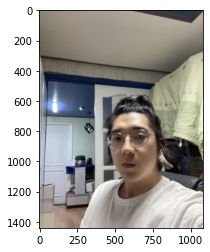

In [4]:
my_image_path = os.getenv('HOME')+'/aiffel/imgs/stand.png'
img_bgr = cv2.imread(my_image_path)
# img_bgr = cv2.resize(img_bgr, (720, 958))

# 아래의 각 용도를 위한 이미지 복사
img_show = img_bgr.copy()
img_bgr2 = img_bgr.copy()
img_addwei = img_bgr.copy()

# 컬러 설정
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

# 얼굴 감지하기

In [5]:
# 얼굴 감지기 호출
detector_hog = dlib.get_frontal_face_detector()
print('Done')

Done


In [6]:
# 탐지
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)  
print('Done')

Done


얼굴 포지션 

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)

rectangles[[(418, 718) (803, 1103)]]


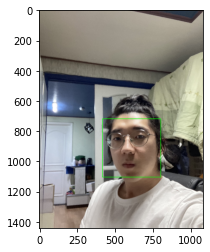

In [7]:
print(dlib_rects)

# 탐지 결과 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 랜드마크 검출하기

In [8]:
# 이미 학습된 랜드마크 모델 가져오기
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
    
print('Done')

Done


In [9]:
# 랜드마크 탐지
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


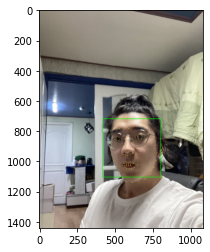

In [10]:
# 랜드마크 위치에 점찍기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

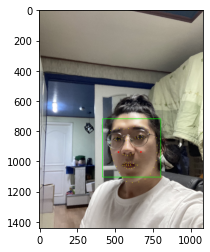

In [11]:
# 주요 교점을 유추하고
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    # 교점 좌표 1
    x1 = landmark[2][0]; y1 = landmark[2][1] # 코 옆 얼굴 점
    x2 = landmark[30][0]; y2 = landmark[30][1] # 콧등 아래쪽
    x3 = landmark[36][0]; y3 = landmark[36][1] # 왼쪽 눈 끝
    x4 = landmark[48][0]; y4 = landmark[48][1] # 왼쪽 입술 끝
    
    # 교점 좌표 2
    x5 = landmark[14][0]; y5 = landmark[2][1] # 코 옆 얼굴 점
    x6 = landmark[30][0]; y6 = landmark[30][1] # 콧등 아래쪽
    x7 = landmark[45][0]; y7 = landmark[36][1] # 오른쪽 눈
    x8 = landmark[54][0]; y8 = landmark[48][1] # 오른쪽 입술
    
    # 교점 좌표 1 계산
    Px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    Py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
    cv2.circle(img_show, (Px,Py), 5, (0, 0, 255), -1)
    
    # 교점 좌표 2 계산
    Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
    Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
    cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)
    
    # 스티커 위치를 위한 높이, 넓이 계산
    w = Px2 - Px
    h = Px2 - Px
    
    img_show = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show)
    plt.show()

# 스티커 준비

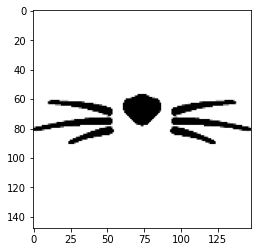

In [12]:
# 스티커 불러오고 출력
sticker_path = os.getenv('HOME')+'/aiffel/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)

# 붙힐 위치에 맞게 이미지 리사이징
img_sticker = cv2.resize(img_sticker, (w,h))

plt.imshow(img_sticker)
plt.show()

In [13]:
# LT좌표 계산
refined_x = Px
refined_y = Py - img_sticker.shape[0]//2

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (524,864)


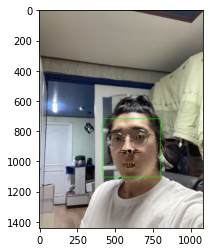

In [14]:
# 스티커 부착
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

sticker_area2 = img_addwei[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
plt.imshow(img_show)

plt.show()

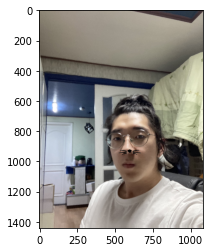

In [15]:
# 랜드마크 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 문제점 탐색

In [16]:
def get_full_path(img_name):
    # 파일 이름을 기반으로 전체 경로 출력
    return os.getenv('HOME')+ f'/aiffel/imgs/{img_name}.png'

def attach_sticker(img_name):
    # 이전 코드와 동일
    my_image_path = get_full_path(img_name)
    sticker_path = os.getenv('HOME')+'/aiffel/cat-whiskers.png'
    
    img_bgr = cv2.imread(my_image_path)

    img_show = img_bgr.copy()
    img_bgr2 = img_bgr.copy()
    img_addwei = img_bgr.copy()

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img_rgb, 1)  
    
    print(dlib_rects)
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
    

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x1 = landmark[2][0]; y1 = landmark[2][1]
        x2 = landmark[30][0]; y2 = landmark[30][1]
        x3 = landmark[36][0]; y3 = landmark[36][1]
        x4 = landmark[48][0]; y4 = landmark[48][1]

        x5 = landmark[14][0]; y5 = landmark[2][1]
        x6 = landmark[30][0]; y6 = landmark[30][1]
        x7 = landmark[45][0]; y7 = landmark[36][1]
        x8 = landmark[54][0]; y8 = landmark[48][1]

        Px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        Py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))//((x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4))
        cv2.circle(img_show, (Px,Py), 5, (0, 0, 255), -1)


        Px2 = ((x5*y6 - y5*x6)*(x7 - x8) - (x5 - x6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        Py2 = ((x5*y6 - y5*x6)*(y7 - y8) - (y5 - y6)*(x7*y8 - y7*x8))//((x5 - x6)*(y7 - y8) - (y5 - y6)*(x7 - x8))
        cv2.circle(img_show, (Px2,Py2), 5, (0, 0, 255), -1)


        w = Px2 - Px
        h = Px2 - Px
        
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    refined_x = Px # left
    refined_y = Py - img_sticker.shape[0]//2
    
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    sticker_area2 = img_addwei[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    fig = plt.figure()

    ax2 = fig.add_subplot(1,2,1)
    ax3 = fig.add_subplot(1,2,2)

    ax2.imshow(img_show_rgb)
    ax3.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

    plt.show()

rectangles[[(418, 718) (803, 1103)]]


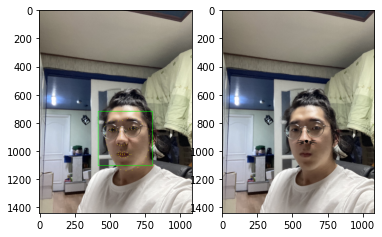

In [17]:
# 테스트를 위해 아까와 동일한 사진 이용
attach_sticker('stand')

rectangles[[(939, 785) (1047, 892)]]


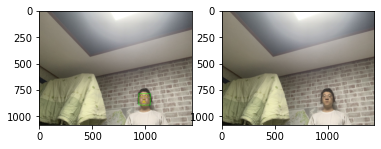

In [18]:
# 멀리 있는 경우
attach_sticker('far')

rectangles[[(194, 605) (656, 1067)]]


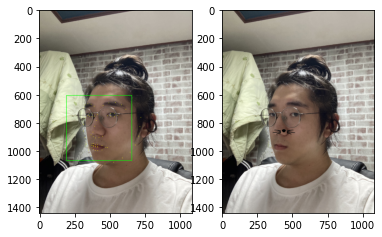

In [19]:
# 옆으로 돌릴때
attach_sticker('side2')

In [20]:
# 어두울 때
attach_sticker('dark')

rectangles[]


UnboundLocalError: local variable 'l' referenced before assignment

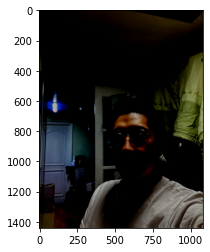

In [21]:
my_image_path = get_full_path('dark')
img_bgr = cv2.imread(my_image_path)
# img_bgr = cv2.resize(img_bgr, (720, 958))

img_show = img_bgr.copy()
img_bgr2 = img_bgr.copy()
img_addwei = img_bgr.copy()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

## 발생한 문제점 정리

### 옆면으로 각도가 틀어질 경우, 거리 계산이 틀어져서 옆으로 이동하는 문제 있음
이를 해결하기 위해서는 얼굴 각도에 대해서 상대적으로 이미지 변환이 필요할 것으로 보인다. (선형 변환등)

### 멀리 있는 경우, 정확한 위치를 파악하기 어렵다.
이번 사례의 경우, 상대적인 크기를 미리 계산해주기 때문에, 잘 드러나지 않았으나, 기본적으로 랜드마크간의 간격이 너무 좁아져서 적절한 위치를 추적하기에 어려움이 있다. 
이미 존재하는 사용 소프트웨어 내에서는 거리가 일정 수준 멀어지면, 이를 처리하지 않도록 예외해주기도한다.

### 어두운 환경에서의 경우, 얼굴을 재대로 탐지하지 못했음
어두운 환경에서 처리를 유도했을 때, 재대로 감지하지 못해서 결국 함수가 실행되지 않았다.
